In [3]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

import matplotlib.pyplot as plt
import pickle

import bamboolib

from fredapi import Fred
fred = Fred(api_key='98d7e668ce51c2997660ab73367c689a')

from tqdm import tqdm

import plotly
import plotly.offline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML
from IPython.core.display import display, HTML
import copy

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from utils.misc import get_fred_asof_history, get_fred_asof
from utils.plotlyhelper import plotly_fig2json

# Plotly settings
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load datasets

In [5]:
df_filename = '../../data/processed/asset_prices_M.pkl'
df_W_filename = '../../data/processed/asset_prices_W.pkl'
bf_filename = '../../data/processed/base_assets_M.pkl'
bf_W_filename = '../../data/processed/base_assets_W.pkl'
kf_asof_filename = '../../data/processed/kf_asof_dataset_M.pkl'
kf_asof_W_filename = '../../data/processed/kf_asof_dataset_W.pkl'

In [6]:
_freq = 'M'

In [7]:
if _freq == 'M':
    one_month = 1
    one_yr = 12
    two_yrs = 24
elif _freq == 'W':
    one_month = 4
    one_yr = 52
    two_yrs = 104

In [8]:
if _freq == 'M':
    df = pd.read_pickle(df_filename)
    bf = pd.read_pickle(bf_filename)
    bf_w = pd.read_pickle(bf_W_filename)
    with open(kf_asof_filename, 'rb') as f:
        kf_asof = pickle.load(f)
elif _freq == 'W':
    df = pd.read_pickle(df_W_filename)
    bf = pd.read_pickle(bf_W_filename)
    with open(kf_asof_W_filename, 'rb') as f:
        kf_asof = pickle.load(f)


# 2. Generate `Macro Factor` indices

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mf = pd.DataFrame(index=bf.index)
mf.index.rename('date', inplace=True)

## 1) Economic Growth

`GRTH` (Growth): A first difference of Composite Leading Indicator (CLI).
- January 1957 to present, **OECD CLI USA**: df.`CLI_USA` at month $t$ - `CLI_USA` at month $t-1$. `CLI_USA` is USA Total Leading Indicators CLI Amplitude Adjusted SA.
- January 1920 to December 1956, **Old CLI USA**: 12-month moving averages of df.`NBM16078USM509S` at month $t$ - 12-month moving averages of `NBM16078USM509S` at month $t-1$. `NBM16078USM509S` is Diffusion Index of Eight Leading Indicators, Three-Six Month Span for United States.

In [10]:
df['OLD_CLI_USA'] = df.NBM16078USM509S.rolling(window=one_yr).mean()

In [11]:
minmax_scaler = MinMaxScaler()
df['CLI_USA_rescaled_recent'] = minmax_scaler.fit_transform(df.CLI_USA.values[:,np.newaxis])*(df.CLI_USA.max() - df.CLI_USA.min()) 
df['CLI_USA_rescaled_older'] = minmax_scaler.fit_transform(df.OLD_CLI_USA.values[:,np.newaxis])*(df.CLI_USA.max() - df.CLI_USA.min())

#### Now we have the equally-scaled continuous CLI  USA from 1919 to present.

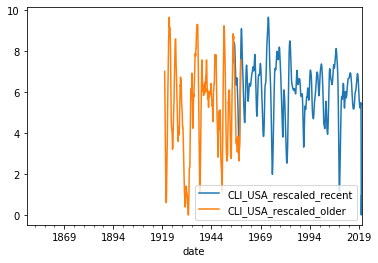

In [12]:
df[['CLI_USA_rescaled_recent', 'CLI_USA_rescaled_older']].plot()

#### Finally, we have `GRTH` as follows:

In [13]:
diff_recent = df.CLI_USA_rescaled_recent - df.CLI_USA_rescaled_recent.shift(one_month)
diff_older = df.CLI_USA_rescaled_older - df.CLI_USA_rescaled_older.shift(one_month)
mf['GRTH'] = diff_recent.loc[diff_recent.index.year>=1957]
mf['GRTH'] = mf.GRTH.fillna(diff_older)

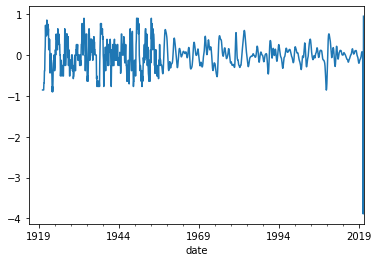

In [14]:
mf.GRTH.plot()

## 2) Inflation

`INFL` (Inflation): A first difference of percentage change in Consumer Price Index YoY
- 1949 to present, **USCPI**: US CPI Urban Consumers YoY NSA at month $t$ - the same at month $t-1$
- Before that date, **CPUSAM_YOY**: This is the underlying index of **USCPI**. So we calculate YoY changes in a percentage term year over year, **CPUSAM_YOY**, and then take first differences.

In [15]:
df['CPUSAM_YOY'] = np.round((df.CPUSAM/df.CPUSAM.shift(one_yr)-1)*100, decimals=1)

In [16]:
(df.CPUSAM_YOY - df.USCPI).describe()

count    870.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [17]:
infl_recent = df.USCPI - df.USCPI.shift(one_month)
infl_older = df.CPUSAM_YOY - df.CPUSAM_YOY.shift(one_month)

In [18]:
mf['INFL'] = infl_recent.fillna(infl_older)

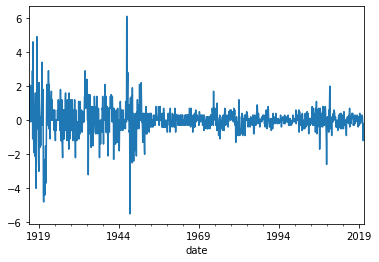

In [19]:
mf.INFL.plot()

We drop pre-1921 data as we did in generating base assets.

In [20]:
mf = mf['1921':]

## 3) Uncertainty

`UNCR` (Uncertainty): 0.5$\cdot$Chicago Fed's National Financial Conditions Index `nfci`  + 0.5$\cdot$Mahalanobis distances of all the base asset returns `d_brt`
- Frequency: Weekly

In [21]:
bf_uncr = bf_w if _freq == 'M' else bf

#### `NFCI`

In [22]:
nfci  = fred.get_series_latest_release('NFCI')
nfci.index = nfci.index.to_period('W-FRI')
nfci.name='nfci'

#### `Base asset weekly returns`

- In calculating base assets' Mahalanobis distances, we take pre-1956 data as in-sample data, implying that we have a forward-looking bias in that period.

In [23]:
X = bf_uncr[:'1955']
bf_emp_cov = EmpiricalCovariance().fit(X)

In [24]:
dt_range = bf_uncr.index
d_brt = {}
for dt in tqdm(dt_range):
    if dt.strftime('%Y-%m') < '1956':
        # For pre-1956, we just take one observation at a time in a sequential order and use a pre-computed covariance matrix over the in-sample period.
        obs = X.loc[dt]
    else:
        # For 1956 or post periods, we increase our dataset by one week at each iteration.
        X = bf_uncr.loc[:dt]
        obs = X.iloc[-1]
        X = X.loc[X.iloc[:-1].index]    # we exclude data on the last day, on which `obs` data occurs.
        bf_emp_cov = EmpiricalCovariance().fit(X)
        
    d_brt[dt] = bf_emp_cov.mahalanobis(obs.values.reshape(1,-1))[0]

100%|█████████████████████████████████████████████████████████████████████████████| 5451/5451 [00:24<00:00, 223.98it/s]


In [25]:
d_brt = pd.DataFrame.from_dict(d_brt, orient='index', columns=['d_brt'])
uncr = pd.merge(d_brt, nfci, how='left', left_index=True, right_index=True)

In [26]:
uncr['d_brt'] = (uncr.d_brt - uncr.d_brt[:-1].mean())/(uncr.d_brt[:-1].std())

In [27]:
uncr.iplot()

#### Imputation

Since we take a simple average of `nfci` and `d_brt` and `nfci` has missing values for pre-1973 periods, we impute `nfci` with `d_brt`.

In [28]:
uncr.nfci.fillna(uncr.d_brt, inplace=True)
uncr['factor'] = 0.5*uncr.nfci + 0.5*uncr.d_brt
uncr.index.name='date'

In [29]:
if _freq == 'M':
    uncr['ym'] = uncr.index.strftime('%Y-%m')
    uncr_m = uncr.groupby('ym').last()
    uncr_m.set_index(pd.to_datetime(uncr_m.index).to_period('M'), inplace=True)
    mf['UNCR'] = uncr_m.factor
elif _freq == 'W':
    mf['UNCR'] = uncr.factor

### Save work

In [30]:
dataset_filename = '../../data/processed/macro_factors_' + _freq
mf.to_csv(dataset_filename + '.log')
mf.to_pickle(dataset_filename + '.pkl')

# 3. Estimate recession probabilities

### Comparisons

In [31]:
lei_idx = [
    ('Labor', 'Average weekly hours, manufacturing'),
    ('Labor','Average weekly initial claims for unemployment insurance'),
    ('Labor', 'Nonfarm payrolls'),
    ('Manufacturing', 'ISM PMI'),
    ('Manufacturing', 'New orders (other goods)'),
    ('>Manufacturing', 'Industrial production'),
    ('Housing', 'Building permits, new private housing units'),
    ('Financial', 'Stock prices'),
    ('Financial', 'Leading Credit Index™'),
    ('Financial', 'Interest rate spread, 10-year Treasury bonds less federal funds'),
    ('Consumer survey','Consumer confidence'),
]
lei_idx = pd.MultiIndex.from_tuples(lei_idx, names=['Markets', 'Names'])
comp = {
    'Conf. Board LEI': ['O', 'O', '', '', 'OOO', '', 'O','O',  'O', 'O', 'O'],
    'OECD CLI USA': ['O', '', '', 'O', 'O', 'O', 'O', 'O', '', 'O', 'O'],
    'KKT Index': ['', '', 'O', '', '', 'O', '', 'O', '', 'O', '']
}

In [32]:
pd.DataFrame(data=comp, index=lei_idx)

Conf. Board LEI  \
Markets         Names                                                                
Labor           Average weekly hours, manufacturing                              O   
                Average weekly initial claims for unemployment ...               O   
                Nonfarm payrolls                                                     
Manufacturing   ISM PMI                                                              
                New orders (other goods)                                       OOO   
>Manufacturing  Industrial production                                                
Housing         Building permits, new private housing units                      O   
Financial       Stock prices                                                     O   
                Leading Credit Index™                                            O   
                Interest rate spread, 10-year Treasury bonds le...               O   
Consumer survey Consumer confidence                                              O   

                                                                   OECD CLI USA  \
Markets         Names                                                             
Labor           Average weekly hours, manufacturing                           O   
                Average weekly initial claims for unemployment ...                
                Nonfarm payrolls                                                  
Manufacturing   ISM PMI                                                       O   
                New orders (other goods)                                      O   
>Manufacturing  Industrial production                                         O   
Housing         Building permits, new private housing units                   O   
Financial       Stock prices                                                  O   
                Leading Credit Index™                                             
                Interest rate spread, 10-year Treasury bonds le...            O   
Consumer survey Consumer confidence                                           O   

                                                                   KKT Index  
Markets         Names                                                         
Labor           Average weekly hours, manufacturing                           
                Average weekly initial claims for unemployment ...            
                Nonfarm payrolls                                           O  
Manufacturing   ISM PMI                                                       
                New orders (other goods)                                      
>Manufacturing  Industrial production                                      O  
Housing         Building permits, new private housing units                   
Financial       Stock prices                                               O  
                Leading Credit Index™                                         
                Interest rate spread, 10-year Treasury bonds le...         O  
Consumer survey Consumer confidence

## (1) Make two sub-samples
- Recession periods
- Robust growth periods

- `rec_months`: 1 if a month belongs to a recession period if ; 0 if expansion.
- `rec_dt`: a Series of months identified as recessions by the NBER.

In [33]:
kf_latest = kf_asof[max(list(kf_asof.keys()))]
earlist_year = kf_latest.index[0].year
rec_months = fred.get_series_latest_release('USREC')
rec_months = rec_months[rec_months.index.year >= earlist_year]

rec_months.index = pd.to_datetime(rec_months.index).to_period('M')
if _freq == 'M':
    rec_dt = pd.Series(rec_months[rec_months==1].index.to_timestamp(), name='rec_date')
elif _freq == 'W':
    rec_months = rec_months.resample('W-FRI', kind='period').ffill()
    rec_dt = pd.Series(rec_months[rec_months==1].index.to_timestamp(freq='W-FRI', how='E'), name='rec_date')

- `rg_threshold` is the `IP` value at the `rg_percentile` relative to the prior `rg_lookback` months (or weeks)

In [34]:
rg_percentile = 75
rg_lookback = 120 if _freq == 'M' else 520
rg_threshold = [np.percentile(kf_latest.IP[n:n+rg_lookback], rg_percentile) for n in range(0,kf_latest.index.shape[0]-rg_lookback)]
rg_threshold = pd.Series(data=rg_threshold, index=kf_latest[-(kf_latest.index.shape[0]-rg_lookback):].index)

- `rg_dt` is robust growth periods identified using `IP` ranked above at `rg_percentile` relative to the prior `rg_lookback` periods.

In [35]:
rg_dt = pd.Series(kf_latest[rg_lookback:].index[kf_latest.IP[rg_lookback:] > rg_threshold].to_timestamp(), name='rg_date')

- Load the OECD CLI USA index for comparison.

In [36]:
cli_usa = fred.get_series_latest_release('USALOLITOAASTSAM')
cli_usa.index = cli_usa.index + MonthEnd(0)

if _freq == 'M':
    cli_usa.index = pd.to_datetime(cli_usa.index).to_period('M')
elif _freq == 'W':
    cli_usa.index = pd.to_datetime(cli_usa.index).to_period('W-FRI')

cli_usa.name = 'OECD_CLI_USA'
cli = pd.DataFrame(index=kf_latest.index[rg_lookback:])
cli = cli.merge(cli_usa, left_index=True, right_index=True, how='left')
cli = cli.apply(lambda col: col.loc[col.first_valid_index():col.last_valid_index()].fillna(method='ffill'))
cli.index = cli.index.to_timestamp(how='E')

In [37]:
from dateutil.relativedelta import *

def get_start_end_dates(dt, _freq):
    '''
    Returns a pair of two lists; start and end. A consecutive period starts from start[n] and ends on end[n].
    
    Arguments:
    dt : Series
        Its values are dates and type is Timestamp 
    
    _freq : string
        either 'M' for monthly or 'W' for weekly
        
    month_end : Boolean
        Change dates in "end" list to %Y-%d-LastDay from %Y-%d-01.
        
    Returns:
    The first list contains start dates and the second list contains end dates.
    '''
    
    if dt.empty:
        return [], []
    
    n = 0
    start = []
    end = []
    start.append(dt.iloc[0])
    prev = dt.iloc[0]
    
    unit_period = relativedelta(months=1) if _freq == 'M' else relativedelta(weeks=1)
    done_flag = False
    
    for d in dt.iloc[1:]:
        if done_flag:
            # As done_flag is marked, we add a start date into the `start` list.
            start.append(prev)
            done_flag = False

        if d != (prev + unit_period):
            # if dates are not consecutive, than it means it's an end point.
            if _freq == 'M':
                end.append(prev + MonthEnd(0))
            elif _freq == 'W':
                end.append(prev)
            
            # Mark this flag as true so that we can append a start date.
            done_flag = True
        
        prev = d
        
    end.append(d)

    return start, end

In [38]:
rec_dt

0     1918-09-01
1     1918-10-01
2     1918-11-01
3     1918-12-01
4     1919-01-01
         ...    
237   2009-06-01
238   2020-03-01
239   2020-04-01
240   2020-05-01
241   2020-06-01
Name: rec_date, Length: 242, dtype: datetime64[ns]

In [39]:
rg_starts, rg_ends = get_start_end_dates(rg_dt[rg_dt>='1956'], _freq)
rec_starts, rec_ends = get_start_end_dates(rec_dt[rec_dt>='1956'], _freq)

In [40]:
rec_starts

[Timestamp('1957-09-01 00:00:00'),
 Timestamp('1960-05-01 00:00:00'),
 Timestamp('1970-01-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1980-02-01 00:00:00'),
 Timestamp('1981-08-01 00:00:00'),
 Timestamp('1990-08-01 00:00:00'),
 Timestamp('2001-04-01 00:00:00'),
 Timestamp('2008-01-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00')]

In [41]:
def multiShades(fig, x0, x1):
    """ Adds shaded areas for specified dates in a plotly plot.
        The lines of the areas are set to transparent using rgba(0,0,0,0)
    """

    # get dict from tuple made by vspan()
    xElem = fig['layout']['shapes'][0]

    # container (list) for dicts / shapes
    shp_lst=[]

    # make dicts according to x0 and X1
    # and edit elements of those dicts
    for i in range(0,len(x0)):
        shp_lst.append(copy.deepcopy(xElem))
        shp_lst[i]['x0'] = x0[i]
        shp_lst[i]['x1'] = x1[i]
        shp_lst[i]['line']['color'] = 'rgba(0,0,0,0)'

    # replace shape in fig with multiple new shapes
    fig['layout']['shapes']= tuple(shp_lst)
    return(fig)

In [42]:
rec_fig = cli.iplot(
    asFigure=True,
    kind='scatter',
    xTitle='Dates',
    yTitle='Returns',
    title='OECD CLI USA with recessions in gray',
    colors='blue',
    vspan={
        'x0': rec_starts,
        'x1': rec_ends,
        'color': 'gray',
        'fill': True,
        'opacity': .4
    }
)

In [43]:
rec_starts = [dt.strftime('%Y-%m-%d') for dt in rec_starts]
rec_ends = [dt.strftime('%Y-%m-%d') for dt in rec_ends]

In [44]:
rec_fig = multiShades(rec_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_fig)

#### Finally we have access to the sub-samples via `rec_dt` and `rg_dt`.
Now `rec_dt` and `rg_dt` have recession periods and robust growth periods, respectively.
- kf_latest.loc[rg_dt.index] returns a dataframe for robust growth periods.

In [45]:
rec_dt = rec_dt[rec_dt.dt.year >= 1926].reset_index(drop = True)

if _freq == 'M':
    all_dt = pd.Series(kf_latest[kf_latest.index.year >= 1926].index.to_timestamp().strftime('%Y-%m'), name='all_dates')
    rec_dt.index = pd.PeriodIndex(rec_dt, freq='M')
    rg_dt.index = pd.PeriodIndex(rg_dt, freq='M')
elif _freq == 'W':
    all_dt = pd.Series(kf_latest[kf_latest.index.year >= 1926].index.to_timestamp(freq='W-FRI', how='E').strftime('%Y-%m-%d'), name='all_dates')
    rec_dt.index = pd.PeriodIndex(rec_dt, freq='W-FRI')
    rg_dt.index = pd.PeriodIndex(rg_dt, freq='W-FRI')
    
all_dt.index = pd.PeriodIndex(kf_latest[kf_latest.index.year >= 1926].index, freq='W-FRI')

## (2) Calculate recession probabilities and robust growth probabilities
- Step 1: Get the Mahalanobis distance for each month's observations from each of the two sub-samples, calling it `d_rec_emp` and `d_rg_emp`
  - A suffix `_emp` is used to emphasize a covariance matrix is an empirical covariance matrix using *past* episodes of recession or robust growth.
- Step 2: Convert each distance into likelihood using the multivariate normal PDF.
- Step 3: Divide a recession distance by the sum of the recession distance and robust growth distance at the same point in time, and interpret the result as a probability of recession. Do the same for a growth distance.

- `X_rec` is the dataset for recession periods
- `X_rg` is the dataset for robust growth periods.

- For pre-1956, we use data that are not available at the time; rather, we use the latest information as of today.
- For the rest of dates, we only use data available at each point in time (we use revisions as well if any).

In [46]:
d_rec = {}
d_rg = {}

d_rec_emp = {}
d_rg_emp = {}

rec_prob = {}
rg_prob = {}

rec_prob_emp = {}
rg_prob_emp = {}

for dt in tqdm(all_dt['1956':]):
    X = kf_asof[dt]   # dataset X available as of `dt`
    X_rec = X.loc[rec_dt[:dt].iloc[:-1].index]  # data during recession periods AND we exclude data on `dt` (by '.iloc[:-1]')
    X_rg = X.loc[rg_dt[:dt].iloc[:-1].index]  # data during robust growth periods AND we exclude data on `dt` (by '.iloc[:-1]')
    obs = X.iloc[-1]  # The latest observation for which the Mahalanobis distance will be calcaulted.
    
    # fit a Minimum Covariance Determinant (MCD) robust estimator to data
    rec_robust_cov = MinCovDet().fit(X_rec)
    rg_robust_cov = MinCovDet().fit(X_rg)
    
    rec_emp_cov = EmpiricalCovariance().fit(X_rec)
    rg_emp_cov = EmpiricalCovariance().fit(X_rg)
    
    # mahalanobis() returns a list, but we only have one observation so that we just take [0].
    d_rec[dt] = rec_robust_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    d_rg[dt] = rg_robust_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    
    d_rec_emp[dt] = rec_emp_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    d_rg_emp[dt] = rg_emp_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    
    # Convert the Mahalanobis distances into likelihood.
    denom_rec = 1/np.sqrt((2*np.pi)*np.linalg.det(rec_robust_cov.covariance_))
    denom_rg = 1/np.sqrt((2*np.pi)*np.linalg.det(rg_robust_cov.covariance_))
    
    # This is likelihood.
    rec_llh = np.exp(-0.5*d_rec[dt])*denom_rec
    rg_llh = np.exp(-0.5*d_rg[dt])*denom_rg
    
    # We divide a likelihood by the sum of the two likelihoods and interprete it as a probability.
    rec_prob[dt] = rec_llh / (rec_llh + rg_llh)
    rg_prob[dt] = rg_llh / (rec_llh + rg_llh)
    
    denom_rec_emp = 1/np.sqrt((2*np.pi)*np.linalg.det(rec_emp_cov.covariance_))
    denom_rg_emp = 1/np.sqrt((2*np.pi)*np.linalg.det(rg_emp_cov.covariance_))
    rec_llh = np.exp(-0.5*d_rec_emp[dt])*denom_rec_emp
    rg_llh = np.exp(-0.5*d_rg_emp[dt])*denom_rg_emp  
    rec_prob_emp[dt] = rec_llh / (rec_llh + rg_llh)
    rg_prob_emp[dt] = rg_llh / (rec_llh + rg_llh)
    

100%|████████████████████████████████████████████████████████████████████████████████| 774/774 [01:20<00:00,  9.62it/s]


Now we have the Mahalanobis distances as follows:
- `d_rec`: from each observation to a recession periods distribution.
- `d_rg`: from each observation to a robust growth periods distibution.

In [47]:
rec_prob_emp = pd.DataFrame.from_dict(rec_prob_emp, orient='index', columns=['recession_prob'])
rg_prob_emp = pd.DataFrame.from_dict(rg_prob_emp, orient='index', columns=['growth_prob'])

if _freq == 'M':
    rec_prob_emp.set_index(pd.PeriodIndex(rec_prob_emp.index, freq='M'), inplace=True)
    rg_prob_emp.set_index(pd.PeriodIndex(rg_prob_emp.index, freq='M'), inplace=True)
elif _freq == 'W':
    rec_prob_emp.set_index(pd.PeriodIndex(rec_prob_emp.index, freq='W-FRI'), inplace=True)
    rg_prob_emp.set_index(pd.PeriodIndex(rg_prob_emp.index, freq='W-FRI'), inplace=True)

### Now we have the `KKT` index that shows recession probabilities in `prob_emp`
- `recession_prob`, `growth_prob`

In [48]:
prob_emp = pd.merge(rec_prob_emp, rg_prob_emp, how='inner', left_index=True, right_index=True)
prob_emp.set_index(prob_emp.index.to_timestamp(freq='W-FRI', how='end'), drop=True, inplace=True)
prob_emp = pd.merge(prob_emp, cli, how='left', left_index=True, right_index=True)
prob_emp['rec_std'] = ((prob_emp.recession_prob - prob_emp.recession_prob.shift(1).rolling(window=one_yr).mean()) / prob_emp.recession_prob.shift(1).rolling(window=one_yr).std())
prob_emp['recession_prob_rising'] = prob_emp[prob_emp.rec_std>=1].recession_prob

In [49]:
prob_emp.set_index(prob_emp.index.normalize(), drop=True, inplace=True)

In [50]:
rec_emp_fig = prob_emp[['recession_prob', 'recession_prob_rising']].iplot(
    asFigure=True,
    kind='scatter',
    xTitle='Dates',
    yTitle='OECD CLI USA (reversed)',
    title='Recession probabilities (Empirical)',
#     secondary_y=['recession_prob', 'recession_prob_rising'],
#     secondary_y_title='Recession probabilities',
    colors=['orange', 'red'],
    width=2,
    vspan={
        'x0': rec_starts,
        'x1': rec_ends,
        'color': 'gray',
        'fill': True,
        'opacity': .3
    })

In [51]:
# rec_emp_fig.layout.yaxis = dict(autorange='reversed')

In [52]:
rec_emp_fig = multiShades(rec_emp_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_emp_fig)

We are interested when this recession probabilities rise. So, we set a threshold as one standard deviation relative to prior one year as indicated in red lines.

### (3) Analysis of predictive powers

We do this only for **monthly** data for easier coding.

In [53]:
import datetime

if _freq == 'M':
    r_pr = prob_emp.recession_prob_rising
    diff = {}
    period_dist = {}
    prob_table = {}
    month_dist = [0, 1, 3, 6, 12, 18]
    for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    #     pred_dt = r_pr[np.logical_and(r_pr>=threshold, r_pr<threshold+0.1)]
        pred_dt = r_pr[r_pr>=threshold]

        # `diff[threshold]` contains period-distances in months or weeks from the date satisfying the `threshold`.
        diff[threshold] = [np.around(((rec_dt + MonthEnd(0)) - dt)/np.timedelta64(1, 'M')).values.astype(int) for dt in pred_dt.index]
        period_dist[threshold] = np.array([np.min(dist[dist>=0]) for dist in diff[threshold]])

        prob_table[threshold] = [np.sum(period_dist[threshold]<=m)/period_dist[threshold].shape[0] for m in month_dist]



### Conclusion: a recession occured over the `N` subsequent months

In [56]:
if _freq == 'M':
    prob_table = pd.DataFrame(prob_table, index=['This month', 'Next 1m', 'Next 3m', 'Next 6m', 'Next 12m', 'Next 18m'])
    prob_table.index.name = 'Above threshold'
    prob_table.style.format("{:.0%}").background_gradient(cmap='Blues')

In [58]:
prob_table.style.format("{:.0%}").background_gradient(cmap='Blues')

,0.5,0.6,0.7,0.8,0.9
Above threshold,,,,,
This month,33%,38%,43%,52%,75%
Next 1m,37%,43%,49%,57%,81%
Next 3m,45%,52%,58%,68%,91%
Next 6m,56%,65%,69%,79%,94%
Next 12m,68%,77%,80%,84%,94%
Next 18m,72%,78%,80%,84%,94%


In [59]:
prob_table_filename = '../../reports/tables/recession_prob'
prob_table.to_pickle(prob_table_filename + '.pkl')

In [55]:
if _freq == 'M':
    rec_starts_idx = pd.to_datetime([datetime.datetime.strptime(dt, "%Y-%m-%d") + MonthEnd(0) for dt in rec_starts])
    rec_ends_idx = pd.to_datetime([datetime.datetime.strptime(dt, "%Y-%m-%d") + MonthEnd(0) for dt in rec_ends])

    dt_idx = {}
    bf_af_prob = {}
    month_range = [str(m) for m in range(-12,20)]
    for m in month_range:
        dt_idx[m] = rec_starts_idx.map(lambda dt:dt + MonthEnd(int(m)))
        bf_af_prob[m] = prob_emp.recession_prob.loc[dt_idx[m]].values

    bf_af_prob = pd.DataFrame(bf_af_prob)
    bf_af_prob = bf_af_prob.melt(value_vars=month_range, var_name='months', value_name='probability')
    bf_af_prob.iplot(kind='scatter', theme='white', x='months', y='probability', categories='months',
                     xTitle='Before/after the start month of recessions in months', yTitle='Recession probabilities',
                     title='Event study' )

### How about weekly?

In [63]:
kkt_W_filename = '../../data/processed/KKT_index_' + _freq
prob_emp_W = pd.read_pickle(kkt_W_filename +  '.pkl')

In [179]:
rec_emp_W_fig = prob_emp_W[['recession_prob', 'OECD_CLI_USA']].iplot(
    asFigure=True,
    kind='scatter',
    xTitle='Dates',
    yTitle='Recession probabilities',
    title='Recession probabilities, a better indicator than OECD CLI USA',
    secondary_y=['OECD_CLI_USA'],
    secondary_y_title='OECD CLI USA (reversed)',
    labels=dict(recession_prob='R'),
    colors=['orange', 'black'],
    width=[2, 1],
    dash=['solid', 'dot'],
    theme='white',
    vspan={
        'x0': rec_starts,
        'x1': rec_ends,
        'color': 'gray',
        'fill': True,
        'opacity': .3
    })

rec_emp_W_fig['layout'].update(yaxis=dict(tickformat='%'), yaxis2=dict(autorange='reversed', showgrid=False))
rec_emp_W_fig.data[0].update(name='Recession probability')
rec_emp_W_fig.data[1].update(name='OECD CLI - USA (rhs)');

In [180]:
rec_emp_W_fig = multiShades(rec_emp_W_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_emp_W_fig)

- Gray areas indicate `recession periods` officially identified by NBER in the chart above.

## Save work

In [ ]:
KKT_index_filename = '../../data/processed/KKT_index_' + _freq
prob_emp.to_pickle(KKT_index_filename + '.pkl')

In [181]:
rec_emp_filename = '../../reports/figures/recession_prob_iplot.json'
plotly_fig2json(rec_emp_W_fig, rec_emp_filename)